In [1]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, degree

import itertools
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from typing import List

## NGraph layer and module definitions

In [2]:
class RecGNNLayer(MessagePassing):
    def __init__(self, ch, aggr='mean'):
        super().__init__(aggr=aggr)
        self.ch = ch
        self.m_mlp = nn.Sequential(
            nn.Linear(ch*3, ch*3),
            nn.ReLU(),
        )
        self.nu_mlp = nn.Sequential(
            nn.Linear(ch*3, ch),
        )
        # self.eu_mlp = nn.Sequential(
        #     nn.Linear(ch*2, ch)
        # )
        with torch.no_grad():
            self.nu_mlp[-1].weight.fill_(0)
            self.nu_mlp[-1].bias.fill_(0)
            # self.eu_mlp[-1].weight.fill_(0)
            # self.eu_mlp[-1].bias.fill_(0)

    def forward(self, nodes, edges, edge_index):
        """
        nodes - [N, ch]
        edges - [E, ch]
        edge_index - [2, E]
        `nodes` and `edges` may have an additional batch dimension.
        """
        node_updates = self.propagate(edge_index, n=nodes, e=edges)
        edge_updates = self.edge_updater(edge_index, e=edges)
        return node_updates, edge_updates

    def message(self, n_i, n_j, e):
        z = torch.cat([n_i, n_j, e], axis=-1)
        return self.m_mlp(z)

    def aggregate(self, m_out, edge_index_i, edge_index_j, n, ptr=None, dim_size=None):
        # Notice the `self.m_ab`, which caches it in the module for later use
        m_a, m_b, self.m_ab = torch.tensor_split(m_out, [self.ch, self.ch*2], -1)
        agg_m_a = self.aggr_module(m_a, edge_index_i, ptr=ptr, dim_size=dim_size, dim=self.node_dim)
        agg_m_b = self.aggr_module(m_b, edge_index_j, ptr=ptr, dim_size=dim_size, dim=self.node_dim)
        return torch.cat([agg_m_a, agg_m_b, n], -1)

    def update(self, a_out):
        return self.nu_mlp(a_out)

    def edge_update(self, e):
        # `self.m_ab` extracted from module state, cached by `self.aggregate`
        # z = torch.cat([self.m_ab, e], -1)
        # return self.eu_mlp(z)
        return self.m_ab


class NGraph(nn.Module):
    def __init__(self, n_layers, n_nodes, ch, **kwargs):
        super(NGraph, self).__init__()

        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.ch = ch
        kwargs['ch'] = ch
        self.layers = nn.ModuleList([RecGNNLayer(**kwargs) for _ in range(n_layers)])

        self.trainable_nodes = nn.Parameter(torch.randn(self.n_nodes, ch))
        self.trainable_edges = nn.Parameter(torch.randn(self.n_nodes**2, ch))

    def grow_forest(self, counts:List[int]):
        dev = self.trainable_nodes.device
        node_range = torch.arange(self.n_nodes).to(dev)
        base_index = torch.cartesian_prod(node_range, node_range).t()
        total = 0

        self.offsets = []
        edge_indices = []
        nodes_list = []
        edges_list = []
        for n in counts:
            nodes = self.trainable_nodes[:n]
            # nodes = torch.cat([
                # self.trainable_nodes,
            #     torch.randn(e, self.ch, device=self.trainable_nodes.device) * k,
            # ], dim=0)
            nodes_list.append(nodes)

            indices = torch.arange(n).to(dev)
            edge_index = torch.cartesian_prod(indices, indices).t()
            edge_indices.append(edge_index + total)

            # edges = torch.randn((self.n_nodes+e)**2, self.ch, device=self.trainable_edges.device) * k
            # idx = torch.arange(self.n_nodes)[None, :] + (self.n_nodes+e)*torch.arange(self.n_nodes)[:, None]
            # edges[idx.flatten()] = self.trainable_edges

            idx = torch.arange(n)[None, :] + (self.n_nodes)*torch.arange(n)[:, None]
            edges = self.trainable_edges[idx.flatten()]
            
            # for i in range(self.n_nodes**2):
            #     j = (edge_index == base_index[:, [i]]).all(0).nonzero().item()
            #     edges[j] = self.trainable_edges[i]
            
            edges_list.append(edges)
            self.offsets.append(total)
            total += n
            
        self.edge_index = torch.cat(edge_indices, dim=1)
        self.nodes = torch.cat(nodes_list, dim=0)
        self.edges = torch.cat(edges_list, dim=0)

    def cycle(self, nodes=True, edges=True, steps=None):
        assert 'nodes' in dir(self) and 'edges' in dir(self), "did you forget to set state?"

        if steps is None:
            steps = len(self.layers)
        
        for i in range(steps):
            layer = self.layers[i % len(self.layers)]
            node_updates, edge_updates = layer(self.nodes, self.edges, self.edge_index)
            assert node_updates.shape == self.nodes.shape and edge_updates.shape == self.edges.shape
            if nodes: self.nodes = self.nodes + node_updates
            if edges: self.edges = self.edges + edge_updates

    def overflow(self, k=5):
        node_overflow = ((self.nodes - self.nodes.clamp(-k, k))**2).mean()
        edge_overflow = ((self.edges - self.edges.clamp(-k, k))**2).mean()
        return node_overflow + edge_overflow

    def apply_vals(self, data, pos, channel=0):
        # data -- [batch, nodes] or [batch, nodes, ch]
        # channels -- int or slice
        assert data.shape[0] == len(self.offsets)

        arange_t = torch.arange(data.shape[1])
        offset_t = torch.tensor(self.offsets)
        indices = arange_t[None, :] + offset_t[:, None] + pos
        ngraph.nodes[indices, channel] = data

    def read_vals(self, nodes, pos, channel=0):
        arange_t = torch.arange(nodes)
        offset_t = torch.tensor(self.offsets)
        indices = arange_t[None, :] + offset_t[:, None] + pos
        return ngraph.nodes[indices, channel]

In [3]:
ngraph = NGraph(n_layers=5, n_nodes=20, ch=8)
ngraph.grow_forest([10, 15, 20])
ngraph.apply_vals(torch.ones(3, 5), 0)
ngraph.cycle()
ngraph.read_vals(8, 0).shape

torch.Size([3, 8])

In [8]:
DEVICE = 'cpu'

X_NODES = 8
Y_NODES = 8
N_NODES = X_NODES + Y_NODES*2

INPUT_POS = 0
LABEL_POS = X_NODES
OUTPUT_POS = X_NODES+Y_NODES

BATCH_SIZE = 32
# CYCLES_PER_EPOCH = 50
# MEM_SIZE = 25
KEY_CHANGE_P = 0

EPOCHS = 2500

In [9]:
ngraph = NGraph(n_layers=5, n_nodes=N_NODES + 0, ch=8).to(DEVICE)
# ngraph.load_state_dict(torch.load('mem2_xl.pt'))
# ngraph.load_state_dict(torch.load('mem3.pt'))
log = []

# asdf = torch.load('mem_again.pt')
# del asdf['edge_index']
# ngraph.load_state_dict(asdf)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(ngraph.parameters(), lr=1e-2)
# optimizer = torch.optim.Adam(ngraph.parameters(), lr=2e-3)
# optimizer = torch.optim.SGD(ngraph.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500)

In [10]:
#     return np.interp(0.4, [0, 1], [10, 20])

def train_loop(ngraph, optimizer, steps,
               cycles_func, mem_func, extra_nodes=0, 
               loss_fn=nn.MSELoss(), scheduler=None, log=None):
    batch_range = torch.arange(BATCH_SIZE, device=DEVICE)

    if log is None:
        log = []

    for step in (bar := tqdm(range(steps))):
        if isinstance(mem_func, int):
            mem_size = mem_func
        else:
            mem_size = int(mem_func(step/steps))
        if isinstance(cycles_func, int):
            cycles = cycles_func
        else:
            cycles = int(cycles_func(step/steps))
        
        key_pool = torch.randn(mem_size, BATCH_SIZE, X_NODES, device=DEVICE)
        val_pool = torch.zeros(mem_size, BATCH_SIZE, Y_NODES, device=DEVICE)

        # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes, ngraph.trainable_edges)
        if isinstance(extra_nodes, np.ndarray):
            ngraph.grow_forest(N_NODES + extra_nodes)
        else:
            assert isinstance(extra_nodes, int)
            ngraph.grow_forest([N_NODES + extra_nodes] * BATCH_SIZE)

        start_nodes_norm = ngraph.nodes.norm()
        start_edges_norm = ngraph.edges.norm()
    
        out_pred = []
        out_true = []
    
        indices = torch.randint(0, mem_size, (cycles, BATCH_SIZE), device=DEVICE)
        for i in indices:
            old_key = key_pool[i, batch_range]
            old_val = val_pool[i, batch_range]
        
            key_change = (torch.rand(BATCH_SIZE, device=DEVICE) < KEY_CHANGE_P).float()[:, None]
            new_key = torch.randn_like(old_key)*key_change + old_key*(1-key_change)
            new_val = torch.randn_like(old_val)*(1-key_change)
        
            key_pool[i, batch_range] = new_key
            val_pool[i, batch_range] = new_val

            # ngraph.nodes[:, INPUT_POS:INPUT_POS+8, 0] = new_key.detach()
            # ngraph.nodes[:, LABEL_POS:LABEL_POS+8, 0] = new_val.detach()
            ngraph.apply_vals(new_key.detach(), INPUT_POS)
            ngraph.apply_vals(new_val.detach(), LABEL_POS)
            ngraph.cycle(nodes=True, edges=False)
            # ngraph.edges = ngraph.edges * 0.95
            ngraph.cycle(nodes=False, edges=True, steps=1)

            # out_pred.append(ngraph.nodes[:, OUTPUT_POS:OUTPUT_POS+8, 0])
            out_pred.append(ngraph.read_vals(Y_NODES, OUTPUT_POS))
            out_true.append(old_val * (1-key_change))
    
        y_hat = torch.stack(out_pred)
        y_true = torch.stack(out_true)
    
        task_loss = loss_fn(y_true, y_hat)
        # node_overflow = ((ngraph.nodes - ngraph.nodes.clamp(-2, 2))**2).mean()
        # edge_overflow = ((ngraph.edges - ngraph.edges.clamp(-1, 1))**2).mean()
        # edge_overflow = ((ngraph.edges - ngraph.edges.clamp(-.1, .1))**2).mean()
        # overflow_loss = node_overflow + edge_overflow
        overflow_loss = ngraph.overflow(2)
        loss = task_loss + overflow_loss
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(ngraph.parameters(), 0.5)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        entry = {
            'loss': task_loss.item(),
            'overflow': overflow_loss.item(),
            'base_nodes_norm': ngraph.trainable_nodes.norm().item(),
            'base_edges_norm': ngraph.trainable_edges.norm().item(),
            'end_nodes_norm': ngraph.nodes.norm().item(),
            'end_edges_norm': ngraph.edges.norm().item(),
            'start_nodes_norm': start_nodes_norm.item(),
            'start_edges_norm': start_edges_norm.item(),
        }
        bar.set_postfix(entry)
        log.append(entry)
    return log

In [11]:
ngraph = NGraph(n_layers=5, n_nodes=N_NODES + 0, ch=8).to(DEVICE)
# ngraph.load_state_dict(torch.load('mem_10_5.pt'))
# ngraph.load_state_dict(torch.load('mem_50_25.pt'))
# ngraph.load_state_dict(torch.load('mem_100_50.pt'))
optimizer = torch.optim.Adam([
    {'params': ngraph.layers.parameters()},
    {'params': [ngraph.trainable_nodes, ngraph.trainable_edges], 'lr':1e-1, 'weight_decay':1e-4},
], lr=1e-2)
# ], lr=1e-2)
# ], lr=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1000, 0.5)

log = train_loop(ngraph, optimizer, 1000, 10, 5, scheduler=scheduler)
# log = train_loop(ngraph, optimizer, 2000, 50, 25, scheduler=scheduler)
# log = train_loop(ngraph, optimizer, 500, 100, 50, scheduler=scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [163]:
log = train_loop(ngraph, optimizer, 100, 10, 5, scheduler=scheduler)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
log = train_loop(ngraph, optimizer, 2000, 50, 25, log=None, scheduler=scheduler)

In [352]:
log = train_loop(ngraph, optimizer, 1000, 20, 10, log=log, scheduler=scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
log = train_loop(ngraph, optimizer, 1000, 30, 15, log=log)

In [ ]:
log = train_loop(ngraph, optimizer, 1000, 40, 20, log=log)

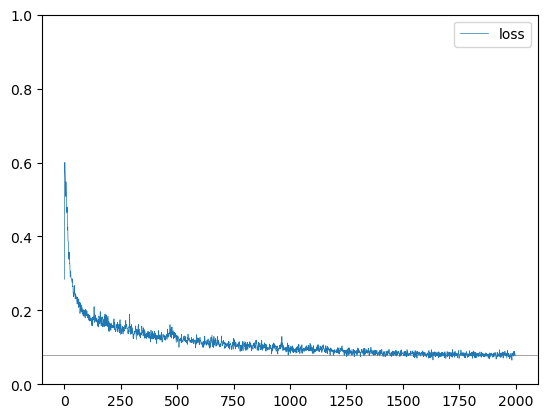

In [66]:
# start from 10_5 model, with scheduler
plt.axhline(0.08, c='gray', lw=0.5)
plt.plot([e["loss"] for e in log], label='loss', lw=0.5)
plt.ylim(0, 1)
plt.legend()
plt.show()

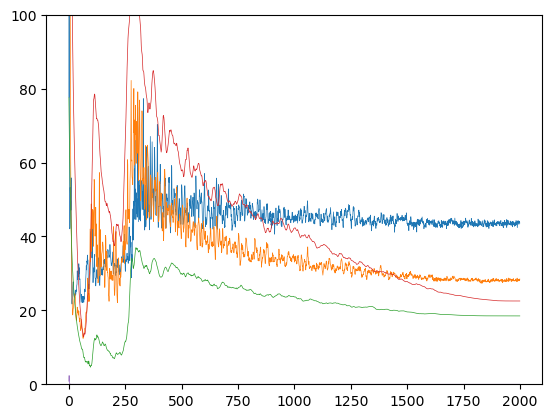

In [124]:
# new impl
plt.plot([e["end_nodes_norm"] for e in log], lw=0.5)
plt.plot([e["end_edges_norm"] for e in log], lw=0.5)
plt.plot([e["start_nodes_norm"] for e in log], lw=0.5)
plt.plot([e["start_edges_norm"] for e in log], lw=0.5)
# plt.plot([e["base_nodes_norm"] for e in log], lw=0.5)
# plt.plot([e["base_edges_norm"] for e in log], lw=0.5)
plt.plot([e["overflow"] for e in log], lw=0.5)
plt.ylim(0, 100)
# plt.legend()
plt.show()

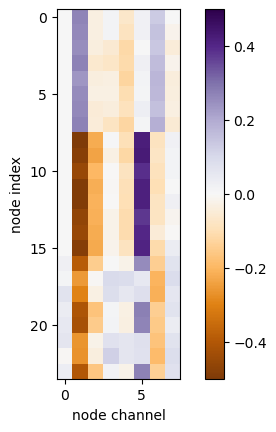

In [953]:
plt.imshow(ngraph.trainable_nodes.detach().cpu(), vmin=-0.5, vmax=0.5, cmap='PuOr')
plt.ylabel('node index')
plt.xlabel('node channel')
plt.colorbar()
plt.show()

In [962]:
ngraph.trainable_edges[(base_index[:, 0] == 0)]

tensor([[ 1.5381e-01,  1.3337e-01,  1.4669e-01, -4.8730e-02, -5.6801e-02,
         -1.4254e-01, -1.7267e-01, -3.2878e-02],
        [ 3.5327e-02,  7.5091e-02,  1.9933e-01,  2.1756e-02, -2.3015e-02,
          1.0402e-01, -1.2025e-03,  5.8164e-02],
        [ 1.7791e-02,  1.0498e-01,  2.1108e-01,  2.3653e-02, -4.8554e-02,
         -6.5669e-03,  3.7447e-02,  3.3175e-02],
        [ 1.1114e-02,  1.1163e-01,  1.6831e-01,  3.8713e-02, -2.3673e-02,
          1.0775e-01,  7.1621e-02, -2.4788e-02],
        [ 3.3855e-02,  7.5695e-02,  1.4588e-01, -3.3852e-03, -4.7945e-03,
          1.9514e-02,  7.3408e-02,  5.7242e-02],
        [ 7.5208e-04,  1.0967e-01,  2.0335e-01,  8.4325e-03, -1.8376e-02,
          3.9576e-02,  4.9347e-02,  2.6122e-02],
        [ 7.1000e-02,  6.9265e-02,  1.6291e-01,  6.3168e-03,  8.4592e-02,
          7.9158e-02,  1.8138e-02,  8.3958e-03],
        [ 2.4797e-02, -4.4335e-03,  2.1100e-01,  1.2700e-02,  6.0365e-03,
          1.2780e-01,  4.6404e-03,  5.7164e-02],
        [-2.9255

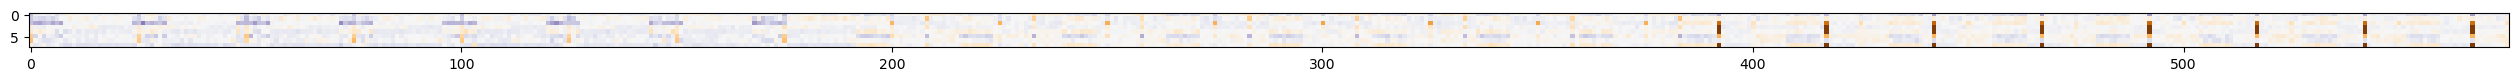

In [972]:
plt.figure(figsize=(32,8))
plt.imshow(ngraph.trainable_edges.detach().cpu().T, vmin=-.5, vmax=0.5, cmap='PuOr')
plt.show()

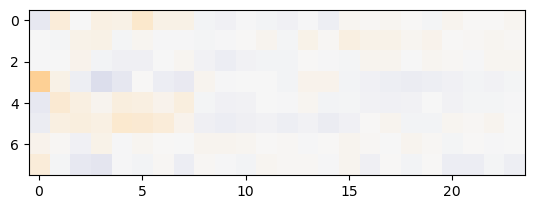

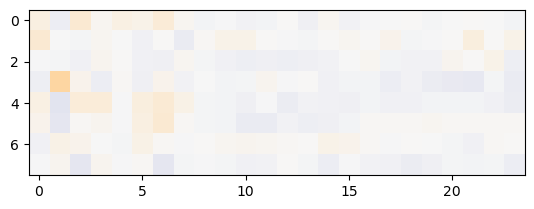

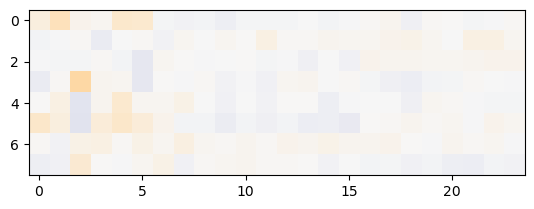

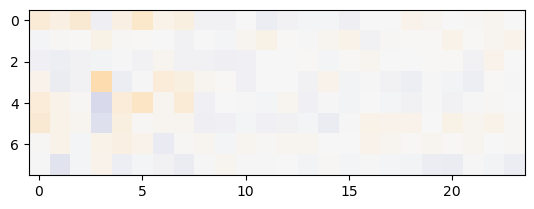

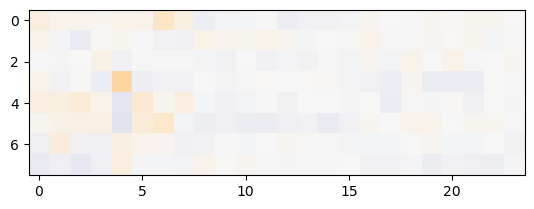

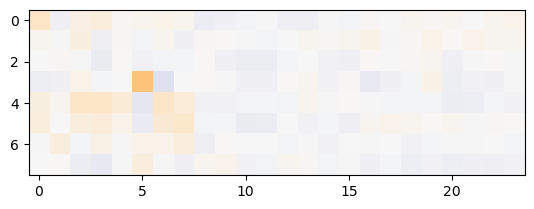

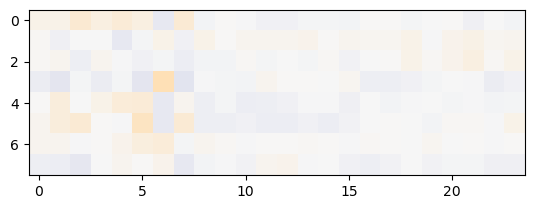

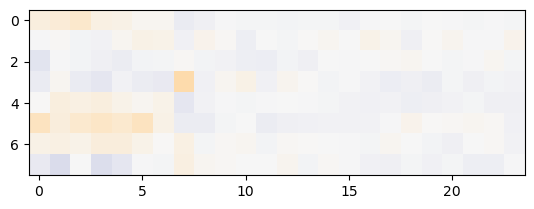

In [1208]:
# i = 0
for i in range(0,8):
# for i in range(8,16):
# for i in range(16,24):
    base_index = torch.cartesian_prod(torch.arange(24), torch.arange(24))
    plt.imshow(ngraph.trainable_edges[base_index[:, 0] == i].detach().cpu().T, vmin=-.5, vmax=0.5, cmap='PuOr')
    plt.show()

In [1306]:
DEVICE = 'cpu'
ngraph = NGraph(n_layers=5, n_nodes=N_NODES + 0, ch=8).to(DEVICE)
# ngraph.load_state_dict(torch.load('mem_10_5.pt'))
ngraph.load_state_dict(torch.load('mem_50_25.pt'))
# ngraph.load_state_dict(torch.load('mem_100_50.pt'))

<All keys matched successfully>

In [1316]:
MEM_SIZE = 10

with torch.no_grad():
    keys = torch.randn(MEM_SIZE, 1, X_NODES, device=DEVICE)
    vals = torch.zeros(MEM_SIZE, 1, Y_NODES, device=DEVICE)

    ngraph.grow_forest([ngraph.n_nodes]*1)
    # ngraph.grow_forest(counts)

In [1317]:
# i = 1
for i in range(MEM_SIZE):
    with torch.no_grad():
        ngraph.apply_vals(keys[i], INPUT_POS)
        ngraph.apply_vals(vals[i], LABEL_POS)
        ngraph.cycle(nodes=True, edges=False)
        ngraph.cycle(nodes=False, edges=True, steps=1)

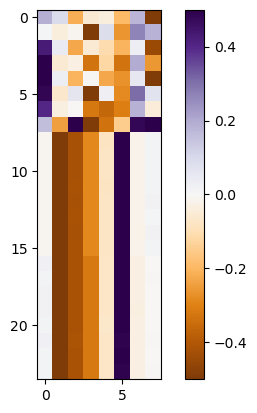

In [1318]:
plt.imshow(ngraph.nodes.detach().cpu(), vmin=-0.5, vmax=0.5, cmap='PuOr')
plt.colorbar()
plt.show()

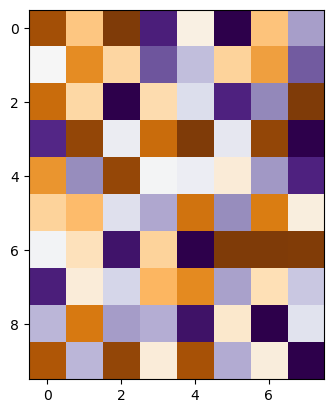

In [1319]:
plt.imshow(keys[:, 0], vmin=-1.5, vmax=1.5, cmap='PuOr')
plt.show()

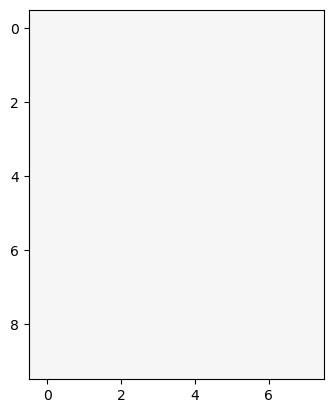

In [1320]:
plt.imshow(vals[:, 0], vmin=-1.5, vmax=1.5, cmap='PuOr')
plt.show()

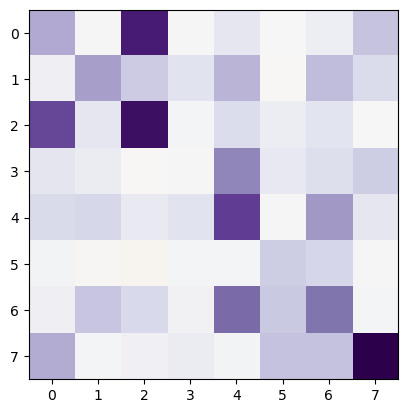

In [1321]:
base_index = torch.cartesian_prod(torch.arange(24), torch.arange(24))
in_nodes = ((0 <= base_index) & (base_index < 8)).all(1)
plt.imshow(ngraph.edges[in_nodes, 7].reshape(8, 8).detach().cpu().T, vmin=-.5, vmax=0.5, cmap='PuOr')
plt.show()

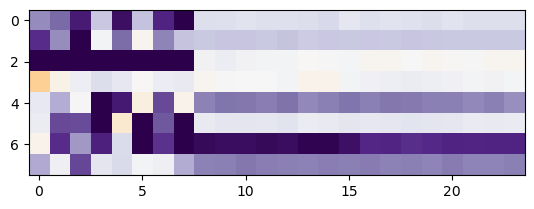

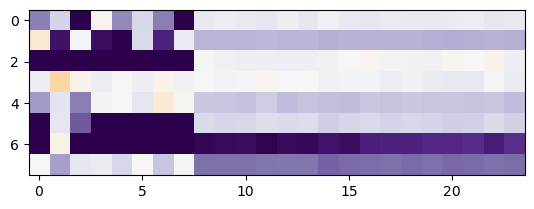

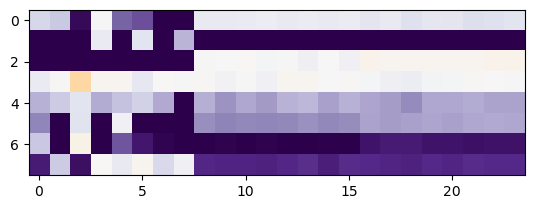

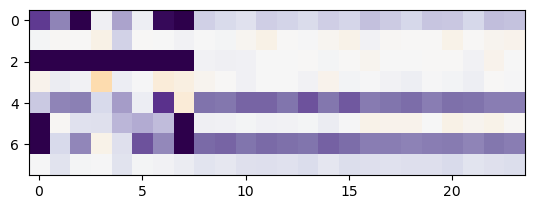

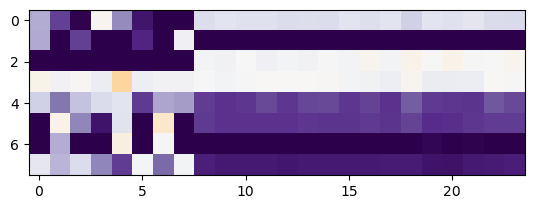

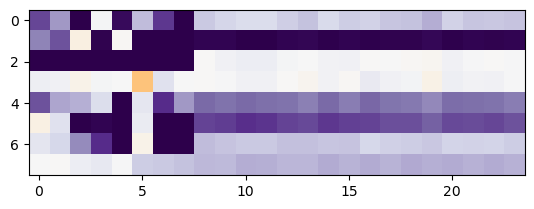

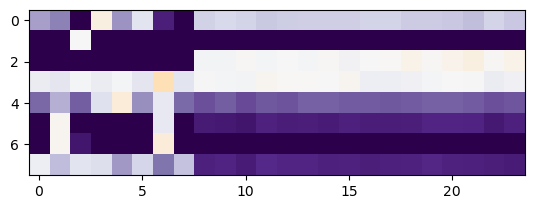

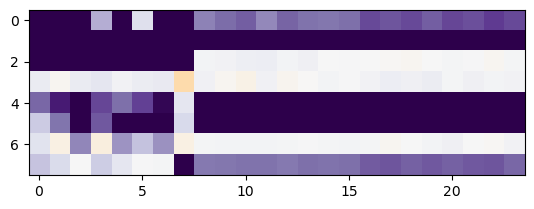

In [1325]:
for i in range(0, 8):
# for i in range(8, 16):
# for i in range(16, 24):
    base_index = torch.cartesian_prod(torch.arange(24), torch.arange(24))
    plt.imshow(ngraph.edges[base_index[:, 0] == i].detach().cpu().T, vmin=-.5, vmax=0.5, cmap='PuOr')
    plt.show()

In [386]:
MEM_SIZE = 1

with torch.no_grad():
    keys = torch.randn(MEM_SIZE, 1, X_NODES, device=DEVICE)
    vals = torch.randn(MEM_SIZE, 1, Y_NODES, device=DEVICE)

    ngraph.grow_forest([ngraph.n_nodes]*1)

    indices = np.arange(MEM_SIZE)

    for _ in tqdm(range(1)):
        # np.random.shuffle(indices)
        for i in indices:
            # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes)
            # label_nodes(ngraph, INPUT_NODES, LABEL_NODES, OUTPUT_NODES)
            ngraph.apply_vals(keys[i], INPUT_POS)
            ngraph.apply_vals(vals[i], LABEL_POS)
            ngraph.cycle(nodes=True, edges=False)
            ngraph.cycle(nodes=False, edges=True, steps=1)

        # print({
        #     'nodes_norm': ngraph.nodes.norm().item(),
        #     'edges_norm': ngraph.edges.norm().item(),
        # })
    
#     out_pred = []
#     for i in range(MEM_SIZE):
#         # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes)
#         # label_nodes(ngraph, INPUT_NODES, LABEL_NODES, OUTPUT_NODES)
#         ngraph.apply_vals(keys[i], INPUT_POS)
#         ngraph.apply_vals(torch.zeros_like(vals[i]), LABEL_POS)
#         ngraph.cycle(nodes=True, edges=False)
#         # ngraph.cycle(nodes=False, edges=True, steps=1)
#         out_pred.append(ngraph.read_vals(Y_NODES, OUTPUT_POS))

#     pred = torch.stack(out_pred)

# nn.functional.mse_loss(pred, vals).cpu().item()

  0%|          | 0/1 [00:00<?, ?it/s]

In [192]:
batch_range = torch.arange(BATCH_SIZE, device=DEVICE)

for step in (bar := tqdm(range(EPOCHS))):
    MEM_SIZE = min(max(2, step // 50), 25)
    CYCLES_PER_EPOCH = min(max(5, step // 25), 50)

    # the good settings:
    # MEM_SIZE = min(max(3, step // 100), 25)
    # CYCLES_PER_EPOCH = min(max(5, step // 50), 50)
    
    # MEM_SIZE = min(max(3, step // 100), 25)
    # CYCLES_PER_EPOCH = min(max(5, step // 10), 50)
    
    key_pool = torch.randn(MEM_SIZE, BATCH_SIZE, X_NODES, device=DEVICE)
    val_pool = torch.zeros(MEM_SIZE, BATCH_SIZE, Y_NODES, device=DEVICE)
    
    # ngraph.grow_forest((N_NODES + np.random.randint(0, 9, BATCH_SIZE)).tolist())
    # ngraph.grow_forest((N_NODES + np.random.randint(1, 4, BATCH_SIZE)).tolist())
    ngraph.grow_forest([N_NODES+0]*BATCH_SIZE)

    out_pred = []
    out_true = []

    indices = torch.randint(0, MEM_SIZE, (CYCLES_PER_EPOCH, BATCH_SIZE), device=DEVICE)
    for i in indices:
        old_key = key_pool[i, batch_range]
        old_val = val_pool[i, batch_range]
    
        key_change = (torch.rand(BATCH_SIZE, device=DEVICE) < KEY_CHANGE_P).float()[:, None]
        new_key = torch.randn_like(old_key)*key_change + old_key*(1-key_change)
        new_val = torch.randn_like(old_val)*(1-key_change)
    
        key_pool[i, batch_range] = new_key
        val_pool[i, batch_range] = new_val

        # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes)
        # label_nodes(ngraph, INPUT_NODES, LABEL_NODES, OUTPUT_NODES)

        ngraph.apply_vals(new_key.detach(), INPUT_POS)
        ngraph.apply_vals(new_val.detach(), LABEL_POS)
        ngraph.cycle(nodes=True, edges=False)
        ngraph.cycle(nodes=False, edges=True, steps=1)

        out_pred.append(ngraph.read_vals(Y_NODES, OUTPUT_POS))
        out_true.append(old_val * (1-key_change))

    y_hat = torch.stack(out_pred)
    y_true = torch.stack(out_true)

    task_loss = loss_fn(y_true, y_hat)
    overflow_loss = ngraph.overflow(5)
    loss = task_loss + overflow_loss
        
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(ngraph.parameters(), 0.5)
    optimizer.step()
    scheduler.step()
    
    entry = {
        'loss': task_loss.item(),
        'overflow': overflow_loss.item(),
    }
    bar.set_postfix(entry)
    log.append(entry)


  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

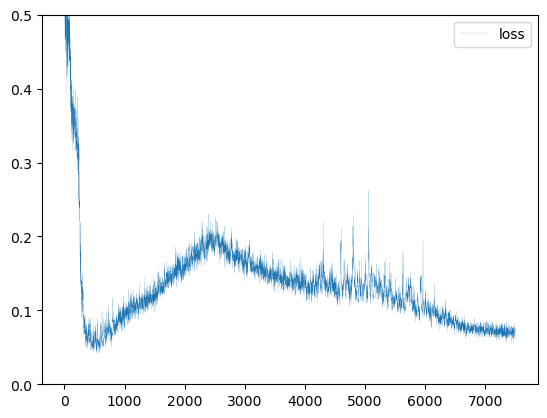

In [46]:
# 1e-2 lr, 2500 ramp up to 50:25, then cosine decay lr for 5000
plt.plot([e["loss"] for e in log], label='loss', lw=0.1)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

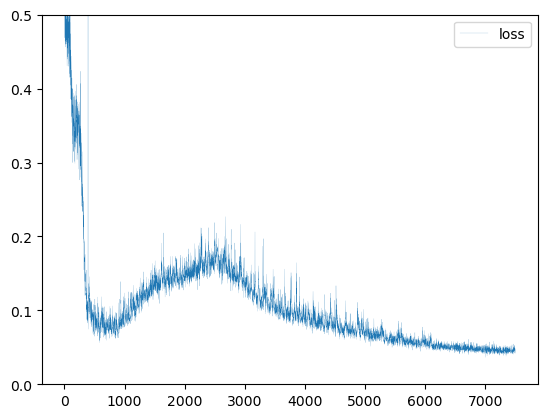

In [168]:
# removed extra nodes
plt.plot([e["loss"] for e in log], label='loss', lw=0.1)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

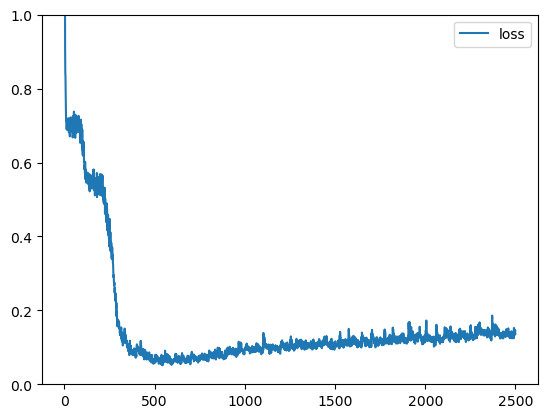

In [25]:
# removed extra nodes
plt.plot([e["loss"] for e in log], label='loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

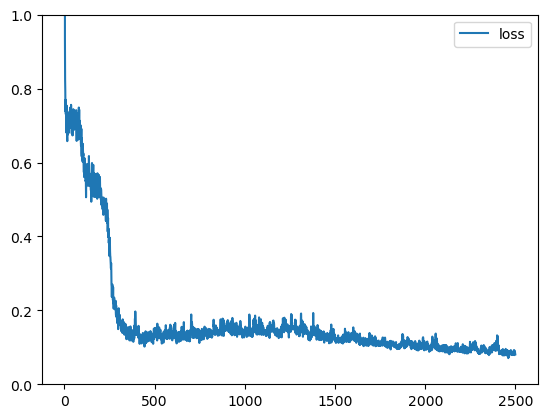

In [21]:
# without edge update
plt.plot([e["loss"] for e in log], label='loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

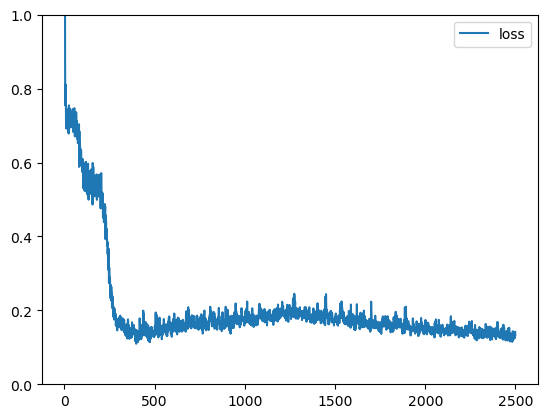

In [29]:
# without edge update
plt.plot([e["loss"] for e in log], label='loss')
plt.ylim(0, 1)
plt.legend()
plt.show()

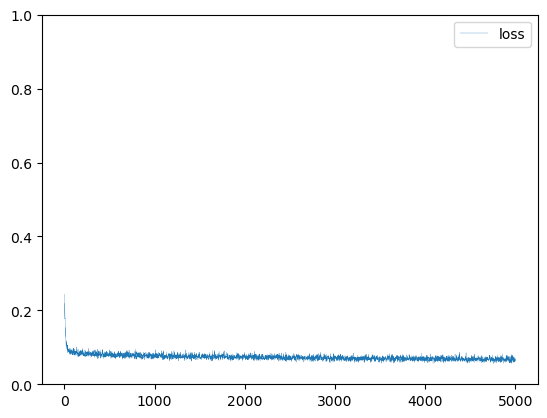

In [37]:
# without edge update
plt.plot([e["loss"] for e in log], label='loss', lw=0.2)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [180]:
torch.save(ngraph.state_dict(), 'mem_10_5.pt')

In [280]:
torch.save(ngraph.state_dict(), 'mem_50_25.pt')

In [351]:
torch.save(ngraph.state_dict(), 'mem_100_50.pt')

In [1141]:
DEVICE = 'cpu'
ngraph = NGraph(n_layers=5, n_nodes=N_NODES + 0, ch=8).to(DEVICE)
# ngraph.load_state_dict(torch.load('mem_10_5.pt'))
ngraph.load_state_dict(torch.load('mem_50_25.pt'))
# ngraph.load_state_dict(torch.load('mem_100_50.pt'))

<All keys matched successfully>

In [1163]:
MEM_SIZE = 10

with torch.no_grad():
    keys = torch.randn(MEM_SIZE, BATCH_SIZE, X_NODES, device=DEVICE)
    vals = torch.randn(MEM_SIZE, BATCH_SIZE, Y_NODES, device=DEVICE)

    # ngraph.grow_forest([4]*BATCH_SIZE, k=0.2)
    ngraph.grow_forest([ngraph.n_nodes]*BATCH_SIZE)
    # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes, ngraph.trainable_edges)

    indices = np.arange(MEM_SIZE)

    print({
            'nodes_norm': ngraph.nodes.norm().item(),
            'edges_norm': ngraph.edges.norm().item(),
        })

    # for _ in tqdm(range(1)):
    #     np.random.shuffle(indices)
    #     for i in indices:
    #         ngraph.apply_vals(torch.randn_like(keys[i]), INPUT_POS)
    #         ngraph.apply_vals(torch.zeros_like(vals[i]), LABEL_POS)
    #         ngraph.cycle(nodes=True, edges=False)
    #         ngraph.cycle(nodes=False, edges=True, steps=1)

    for _ in tqdm(range(2)):
        np.random.shuffle(indices)
        for i in indices:
            # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes)
            # label_nodes(ngraph, INPUT_NODES, LABEL_NODES, OUTPUT_NODES)
            ngraph.apply_vals(keys[i], INPUT_POS)
            ngraph.apply_vals(vals[i], LABEL_POS)
            ngraph.cycle(nodes=True, edges=False)
            ngraph.cycle(nodes=False, edges=True, steps=1)

        print({
            'nodes_norm': ngraph.nodes.norm().item(),
            'edges_norm': ngraph.edges.norm().item(),
        })

    
    for _ in tqdm(range(50)):
        for i in range(MEM_SIZE):
            ngraph.apply_vals(torch.randn_like(keys[i]), INPUT_POS)
            ngraph.apply_vals(torch.randn_like(vals[i]), LABEL_POS)
            ngraph.cycle(nodes=True, edges=False)
            # ngraph.cycle(nodes=False, edges=True, steps=1)
            out_pred.append(ngraph.read_vals(Y_NODES, OUTPUT_POS))

    # print({
    #         'nodes_norm': ngraph.nodes.norm().item(),
    #         'edges_norm': ngraph.edges.norm().item(),
    #     })

    
    out_pred = []
    for i in range(MEM_SIZE):
        # ngraph.set_state(BATCH_SIZE, ngraph.trainable_nodes)
        # label_nodes(ngraph, INPUT_NODES, LABEL_NODES, OUTPUT_NODES)
        ngraph.apply_vals(keys[i], INPUT_POS)
        ngraph.apply_vals(torch.zeros_like(vals[i]), LABEL_POS)
        ngraph.cycle(nodes=True, edges=False)
        # ngraph.cycle(nodes=False, edges=True, steps=1)
        out_pred.append(ngraph.read_vals(Y_NODES, OUTPUT_POS))

    pred = torch.stack(out_pred)

nn.functional.mse_loss(pred, vals).cpu().item()

{'nodes_norm': 10.355324745178223, 'edges_norm': 20.534576416015625}


  0%|          | 0/2 [00:00<?, ?it/s]

{'nodes_norm': 33.02345657348633, 'edges_norm': 118.8487777709961}
{'nodes_norm': 38.62122344970703, 'edges_norm': 140.1838836669922}


  0%|          | 0/50 [00:00<?, ?it/s]

0.03572848439216614

In [1073]:
# with torch.no_grad():
#     # ngraph.grow_forest([4]*BATCH_SIZE, k=0.2)
#     data = ngraph.read_vals(4, 24).cpu()
#     plt.imshow(data - data.mean(), vmin=-.2, vmax=.2, cmap='PuOr')
#     plt.show()

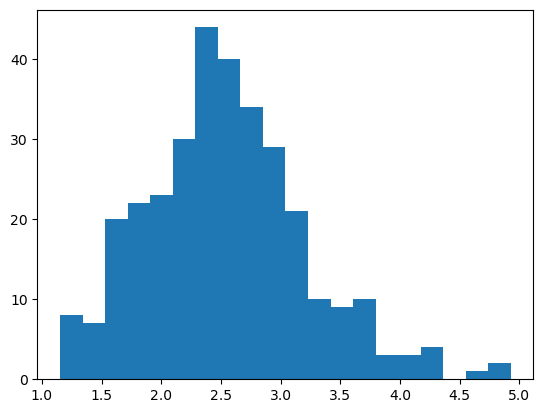

In [1143]:
plt.hist(pred.cpu().norm(dim=-1).numpy().flatten(), bins=20)
plt.show()

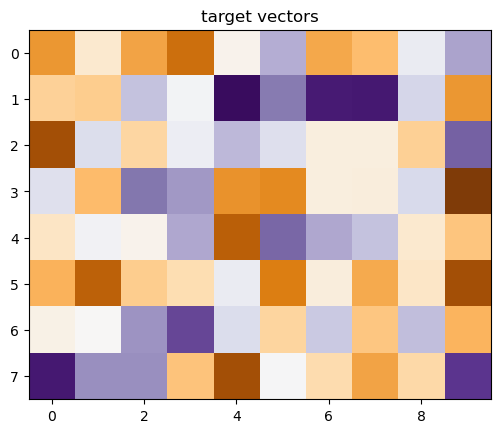

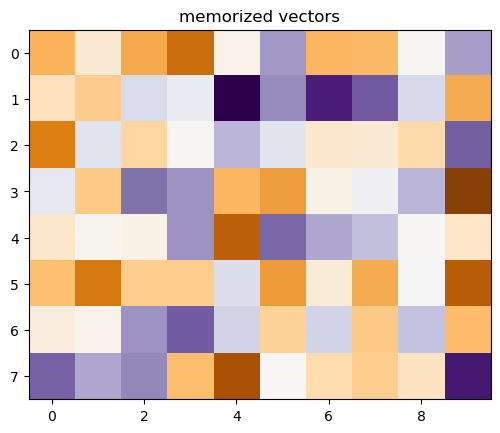

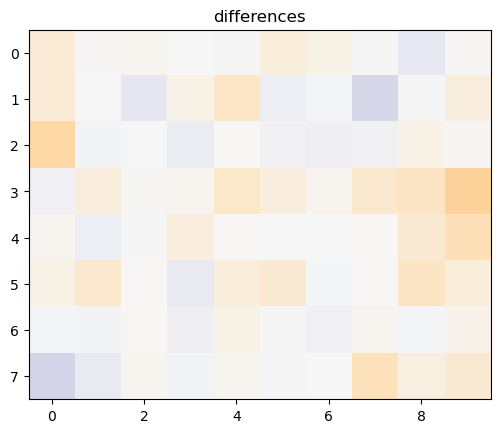

In [1149]:
i = 4
plt.imshow(vals[:,i].cpu().T, vmin=-2, vmax=2, cmap='PuOr', )
plt.title('target vectors')
plt.show()
plt.imshow(pred[:,i].cpu().T, vmin=-2, vmax=2, cmap='PuOr')
plt.title('memorized vectors')
plt.show()
plt.imshow((vals - pred)[:,i].cpu().T, vmin=-2, vmax=2, cmap='PuOr')
plt.title('differences')
plt.show()